# 2D Projection of Protein Embeddings

## Dependencies

In [1]:
# ! pip install amplify umap-learn

In [ ]:
import torch
import numpy as np
from umap import UMAP
from functools import partial
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from utils import load_csv_dataset, load_from_hf, load_from_mila

In [3]:
# Model
source = "mila"
model_name = "AMPLIFY350M"
model_path = "../outputs/MILA_PLM_350M_UR100P/checkpoint/pytorch_model.pt"
tokenizer_path = None 
config_path = "../outputs/MILA_PLM_350M_UR100P/checkpoint/config.yaml"
batch_size = 8
device = "cuda"
compile = False
fp16 = True

# Dataset
data_name = "UniProt"
data_path = "../uniref/mila/uniprot_dev.csv"
n_proteins = 1000

# UMAP
n_last_layers = 1
n_neighbors = 100
min_dist = 0.1
n_epochs = 1000

# Log
output_file = "../outputs/AMPLIFY_UniProt_UMAP.csv"

In [4]:
# Get model and tokenizer
if source == "hf":
    model, tokenizer = load_from_hf(model_path, tokenizer_path, fp16=fp16)
elif source == "mila":
    model, tokenizer = load_from_mila(model_path, config_path)
else:
    raise Exception("Only 'hf' and 'mila' sources are supported, not {source}.")
model.to(device)
torch.compile(model, disable=~compile)

In [5]:
# Prepare the dataset
dataset = load_csv_dataset(data_path, n_proteins)

def tokenize(dataset, tokenizer):
    tokenized_dataset = []
    for label, protein in dataset:
        tokenized_protein = torch.as_tensor(tokenizer.encode(protein, max_length=1024, truncation=True))
        tokenized_dataset.append([label, tokenized_protein.to(torch.long)])
    return tokenized_dataset

def collate(batch, pad_token_id):
    name, inputs = zip(*batch)
    max_length = ((max(x.size(0) for x in inputs) // 8) + 1) * 8
    pad_x = torch.full((len(inputs), max_length), fill_value=pad_token_id)
    for i, x in enumerate(inputs):
        pad_x[i, : x.size(0)] = x
    pad_mask = pad_x == pad_token_id
    return name, pad_x, pad_mask

dataloader = DataLoader(
    tokenize(dataset, tokenizer),
    batch_size=batch_size,
    collate_fn=partial(collate, pad_token_id=tokenizer.pad_token_id),
    pin_memory=True,
    num_workers=4,
)

In [6]:
# Get the protein embeddings
with torch.no_grad(), torch.autocast(device_type=device, dtype=torch.float16, enabled=fp16):
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    labels, embeddings = [], []
    for name, x, pad_mask in dataloader:
        x, pad_mask = x.to(device), pad_mask.to(device)      
        if source == "hf":
            hf_pad_mask = torch.where(pad_mask, float(0.0), float(1)).half()
            hidden_representation = model(x, hf_pad_mask, output_hidden_states=True).hidden_states[-n_last_layers:]
        elif source == "mila":
            mila_pad_mask = torch.where(pad_mask, float("-inf"), float(0.0)).half()
            hidden_representation = model(x, mila_pad_mask, output_hidden_states=True).hidden_states[-n_last_layers:]
        hidden_representation = torch.stack(hidden_representation).sum(0)
        hidden_representation = torch.masked_fill(hidden_representation, pad_mask.unsqueeze(-1), 0)
        labels.extend(name)
        embeddings.extend(hidden_representation.sum(1).cpu().tolist())
    embeddings = np.asarray(embeddings)

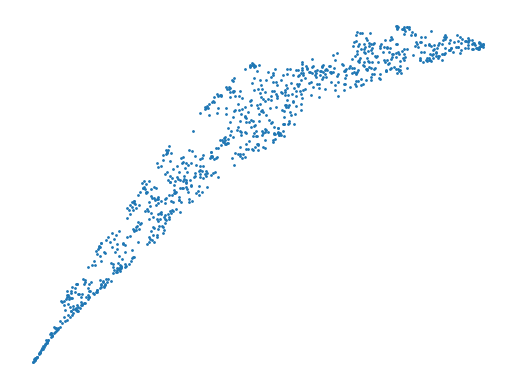

In [7]:
# 2D projection with UMAP
reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_epochs=n_epochs, low_memory=False)
projection = reducer.fit_transform(embeddings)

# Save the projection into a csv
with open(output_file, "w") as file:
    file.write("protein,x,y\n")
    for label, (x, y) in zip(labels, projection):
        file.write(f"{label},{x},{y}\n")

# Plot the projection
plt.scatter(projection.T[0], projection.T[1], s=1)
plt.axis("off")
plt.show()